# Comparison of two VonMisesFisher sampler implementations

2
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


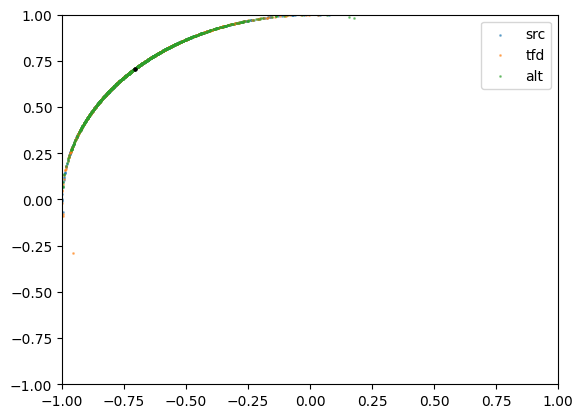

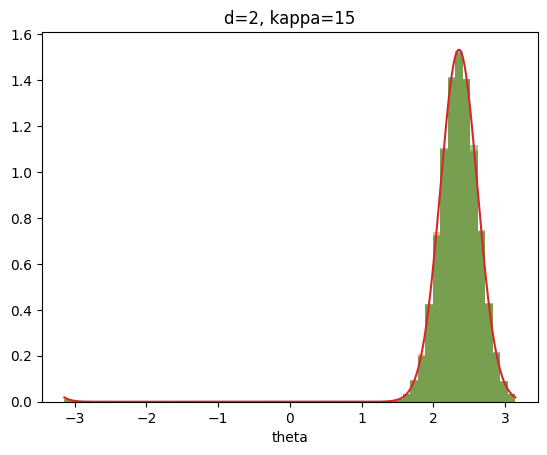

In [1]:
from importlib import reload
import VMF_alt
reload(VMF_alt)
from VMF_alt import random_VMF, theta_arg_max
from VMF_src import rand_von_mises_fisher, plot_3d_scatter, rand_uniform_hypersphere
import matplotlib.pyplot as plt
import numpy as np
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Hide unnecesary tensorflow logs about GPU
import tensorflow_probability as tfp
tfd = tfp.distributions


n = 10**5
d = 2
theta0 = 135 * np.pi / 180
mu = np.array([np.cos(theta0), np.sin(theta0)])
kappa = 15

x1 = rand_von_mises_fisher(mu, kappa, n)
x2 = random_VMF(mu, kappa, n)
x3 = tfd.VonMisesFisher([*mu.astype(float)], float(kappa)).sample(n).numpy()

mask = np.random.random(n) < 1000/n
plt.scatter(x1[mask,0], x1[mask,1], s=1, alpha=0.5, label="src")
plt.scatter(x2[mask,0], x2[mask,1], s=1, alpha=0.5, label="tfd")
plt.scatter(x3[mask,0], x3[mask,1], s=1, alpha=0.5, label="alt")
plt.scatter([mu[0]], [mu[1]], color='black', s=5)
plt.legend()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

theta1 = np.arctan2(x1[:,1], x1[:,0])
theta2 = np.arctan2(x2[:,1], x2[:,0])
theta3 = np.arctan2(x3[:,1], x3[:,0])
plt.hist(theta1, alpha=0.5, density=True, bins=60, label="src")
plt.hist(theta2, alpha=0.5, density=True, bins=60, label="tfd")
plt.hist(theta3, alpha=0.5, density=True, bins=60, label="alt")
plt.title(f"d={d}, kappa={kappa}")

theta = np.linspace(-np.pi,np.pi, 10**4)
with np.errstate(over="raise", divide="raise"):
    try:
        Y = np.exp(kappa*np.cos(theta-theta0))
        Y /= np.trapz(Y, x=theta)
    except FloatingPointError:
        Y = np.exp(np.cos(theta-theta0))
        Y /= np.max(Y)
        Y = Y**kappa
        Y /= np.trapz(Y, x=theta)
plt.plot(theta, Y, label='theory')
plt.xlabel('theta')
plt.show()


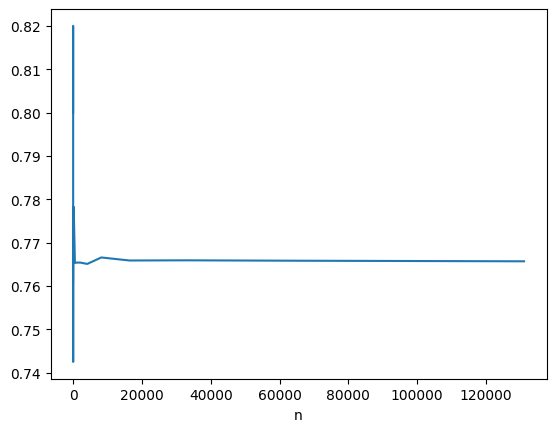

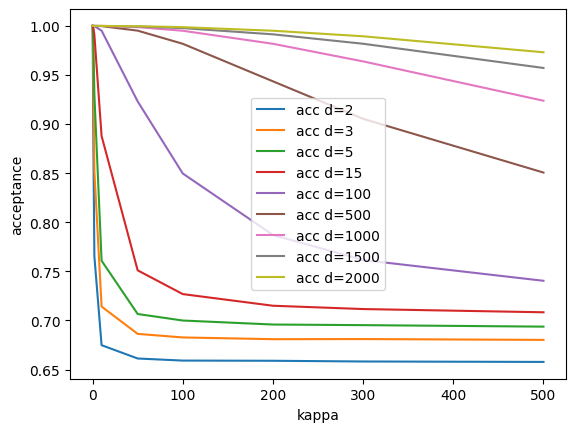

In [218]:
import timeit
import VMF_alt
reload(VMF_alt)
from VMF_alt import random_VMF, theta_arg_max, _acceptance_test


out = []

def f(extra_p):
    for kappa in [50, 100, 1e3]:
        for d in [2, 3, 5, 15]:
            #print(f"kappa={kappa}, d={d}")
            _acceptance_test(d, kappa, n)
    return

# for n in [1,2,3,5,100,1000,10000,100000]:
#     nTimeIt = max(1, int(10000 / n**0.5))
#     for extra_p in [0.0,0.02,0.05, 0.1, 0.3]:
#         print(n, extra_p, timeit.timeit(lambda: f(extra_p), number=nTimeIt) / nTimeIt * 1e3)

kappa = 2.0
d = 2
N = 2**np.arange(18)
out = np.array([_acceptance_test(d, kappa, n, repeat=50) for n in N])
plt.plot(N, out[:,0], label="acc")
plt.xlabel('n')
plt.show()
# plt.plot(N, out[:,1], label="time")
# plt.xlabel('n')
# plt.show()

Out = []
Kappa = [1e-3, 1e-1, 1, 2, 10, 50, 100, 200,300,500]
n = 20000
D = [2, 3, 5, 15, 100, 500, 1000, 1500, 2000]
for d in D:
    out = np.array([_acceptance_test(d, kappa, n, repeat=100) for kappa in Kappa])
    Out.append(out[:,0])

for d, out in zip(D, Out):
    plt.plot(Kappa, out, label=f"acc d={d}")
plt.ylabel('acceptance')
plt.xlabel('kappa')
plt.legend()
plt.show()
# plt.plot(N, out[:,1], label="time")
# plt.xlabel('n')
# plt.show()


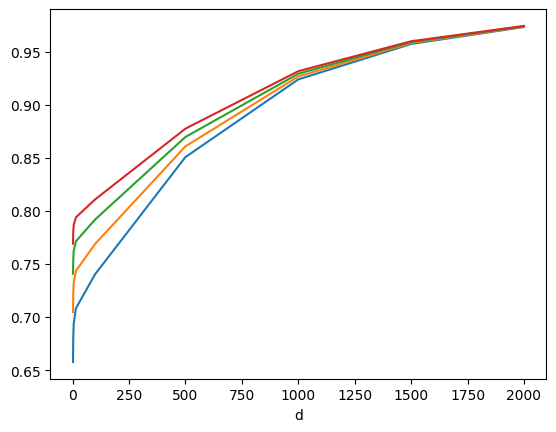

In [295]:

# for d, out in zip(D, Out):
#     plt.plot(Kappa, out, label=f"acc d={d}")

end = np.array([out[-1] for out in Out])
# end -= 0.6577
# end /= 1-0.657
# plt.plot(D, end)
# plt.plot(D, end/(1-end))
# plt.plot(D, 1/(1-end))
# plt.plot(D, 1/(1-end)**0.5)
plt.plot(D, end)
end = 1/(1 - np.log(end))
plt.plot(D, end)
end = 1/(1 - np.log(end))
plt.plot(D, end)
plt.plot(D, 1/(1-np.log(end)))
# plt.plot(D, -np.log(end))
# plt.plot(D, 1/(1-end)**0.5 - np.array(D)/450)
# plt.plot(D, np.log(1/(1-end)) - 1.05 - np.array(D)/800)
# plt.ylabel('acceptance')
plt.xlabel('d')
plt.show()

0.657739

In [2]:
import timeit

n = 1000
nTimeIt = 100
for kappa in [1, 50]:
    for d in [2, 3, 5, 15]:
        print(f"kappa={kappa}, d={d}")
        mu = rand_uniform_hypersphere(1, d)[0]

        f1 = lambda: rand_von_mises_fisher(mu, kappa, n)
        t1 = timeit.timeit(f1, number=nTimeIt) / nTimeIt * 1e3
        print(f"  src: {t1:.2f}ms")

        f2 = lambda: tfd.VonMisesFisher([*mu.astype(float)], float(kappa)).sample(n).numpy()
        t2 = timeit.timeit(f2, number=nTimeIt) / nTimeIt * 1e3
        print(f"  tfd: {t2:.2f}ms")

        f3 = lambda: random_VMF(mu, kappa, n)
        t3 = timeit.timeit(f3, number=nTimeIt) / nTimeIt * 1e3
        print(f"  alt: {t3:.2f}ms")


kappa=1, d=2
  src: 8.17ms
  tfd: 41.67ms
  alt: 0.68ms
kappa=1, d=3
  src: 6.66ms
  tfd: 9.57ms
  alt: 0.77ms
kappa=1, d=5
  src: 7.30ms
  tfd: 26.04ms
  alt: 0.80ms
kappa=1, d=15
  src: 6.82ms
  tfd: 22.57ms
  alt: 1.13ms
kappa=50, d=2
  src: 8.63ms
  tfd: 65.10ms
  alt: 0.81ms
kappa=50, d=3
  src: 9.57ms
  tfd: 9.58ms
  alt: 0.87ms
kappa=50, d=5
  src: 9.24ms
  tfd: 58.51ms
  alt: 0.75ms
kappa=50, d=15
  src: 8.87ms
  tfd: 51.29ms
  alt: 1.05ms


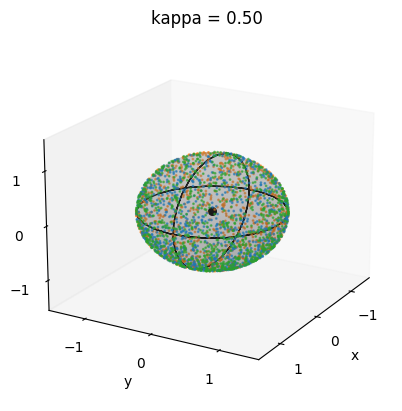

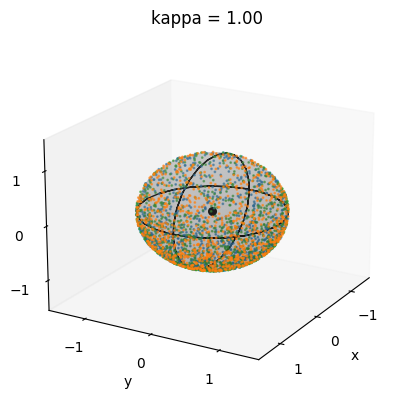

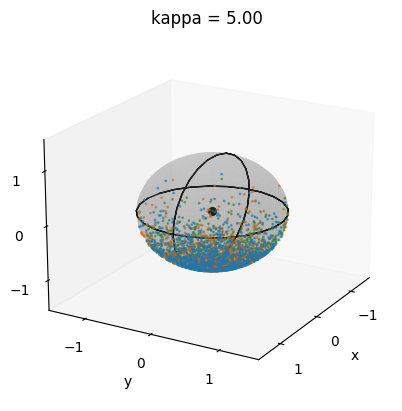

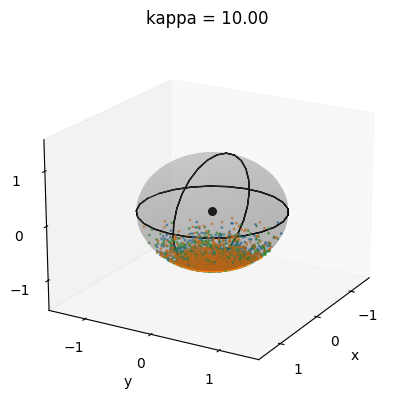

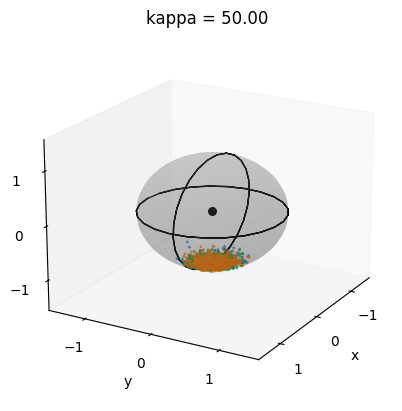

In [3]:
d = 3
n = 1000
mu = np.array([0, 0, -1])


for kappa in [0.5, 1, 5, 10, 50]:
    x1 = rand_von_mises_fisher(mu, kappa, n)
    x2 = tfd.VonMisesFisher([*mu.astype(float)], float(kappa)).sample(n).numpy()
    x3 = random_VMF(mu, kappa, n)

    ax = plot_3d_scatter(
        np.zeros((1, 3)), colour="black", sph=True, sph_alpha=0.2,
    )

    kw = {"s": 1, "alpha": 0.6}
    ax.scatter(x1[:, 0], x1[:, 1], x1[:, 2], label="src", **kw)
    ax.scatter(x2[:, 0], x2[:, 1], x2[:, 2], label="tfd", **kw)
    ax.scatter(x3[:, 0], x3[:, 1], x3[:, 2], label="alt", **kw)
    ax.view_init(20,30)
    plt.title(f"kappa = {kappa:.02f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
